In [2]:
# Grab Data and Set up Shop

In [3]:
import os
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Use your real API key here
fred = Fred(api_key="ab546902ed575b0eb5ddfe4b8b4605cf")

start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime.today()

# Pull 2-year and 10-year Treasury yields
dgs2 = fred.get_series('DGS2', observation_start=start_date, observation_end=end_date)
dgs10 = fred.get_series('DGS10', observation_start=start_date, observation_end=end_date)

# Convert to DataFramesource .venv/bin/activate

yields_df = pd.DataFrame({'2yr': dgs2, '10yr': dgs10})
yields_df.dropna(inplace=True)


In [4]:
print(yields_df.head())

             2yr  10yr
2000-01-03  6.38  6.58
2000-01-04  6.30  6.49
2000-01-05  6.38  6.62
2000-01-06  6.35  6.57
2000-01-07  6.31  6.52


In [5]:


# Construct the Spread
# LGF



In [6]:
yields_df['spread'] = yields_df['10yr'] - yields_df['2yr']
print(yields_df.head())
yields_df[['2yr','10yr','spread']].describe()

             2yr  10yr  spread
2000-01-03  6.38  6.58    0.20
2000-01-04  6.30  6.49    0.19
2000-01-05  6.38  6.62    0.24
2000-01-06  6.35  6.57    0.22
2000-01-07  6.31  6.52    0.21


,2yr,10yr,spread
count,6259.000000,6259.000000,6259.000000
mean,2.200337,3.284597,1.084259
std,1.773467,1.305830,0.983049
min,0.090000,0.520000,-1.080000
25%,0.630000,2.205000,0.210000
50%,1.700000,3.320000,1.140000
75%,3.750000,4.280000,1.910000
max,6.930000,6.790000,2.910000


In [7]:
# Exploratory Data Analysis

In [8]:
print(yields_df['spread'].describe())

count    6259.000000
mean        1.084259
std         0.983049
min        -1.080000
25%         0.210000
50%         1.140000
75%         1.910000
max         2.910000
Name: spread, dtype: float64


In [9]:
# Plot the Spread

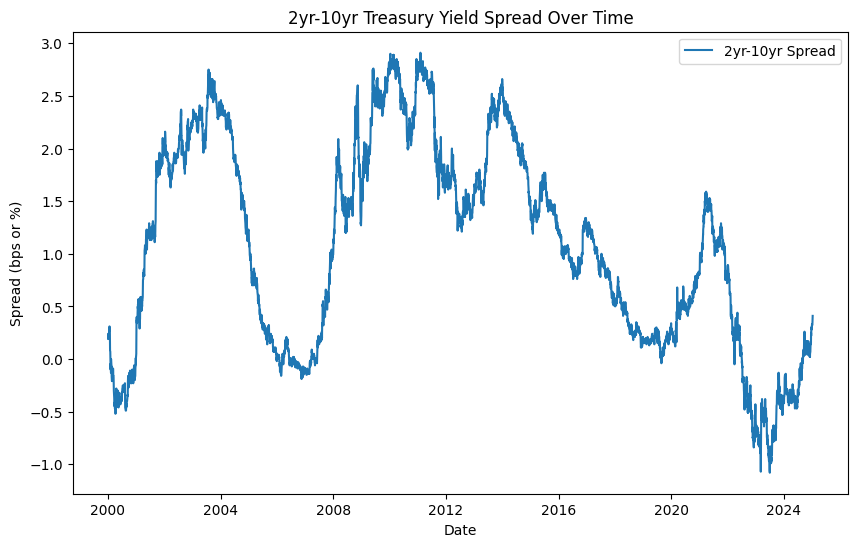

In [10]:
plt.figure(figsize=(10,6))
plt.plot(yields_df.index, yields_df['spread'], label='2yr-10yr Spread')
plt.title('2yr-10yr Treasury Yield Spread Over Time')
plt.xlabel('Date')
plt.ylabel('Spread (bps or %)')
plt.legend()
plt.show()

In [11]:
# Augmented Dickey-Fuller (ADF) Test:

In [12]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(yields_df['spread'].dropna())
print("ADF Statistic: ", adf_result[0])
print("p-value: ", adf_result[1])


ADF Statistic:  -1.8901278816783114
p-value:  0.33671942345834566


In [13]:
# Autocorrelation Plots

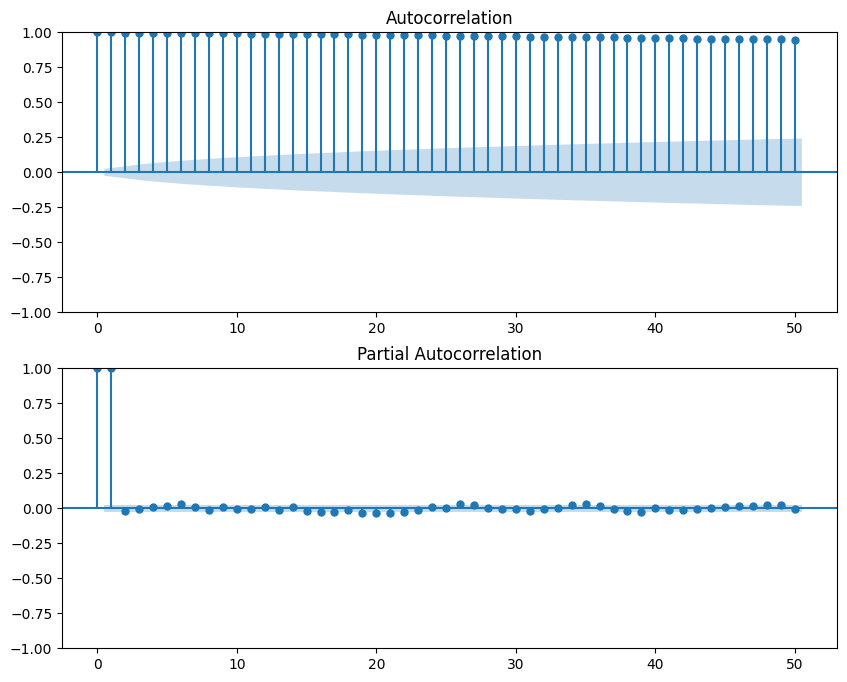

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(yields_df['spread'].dropna(), ax=ax[0], lags=50)
plot_pacf(yields_df['spread'].dropna(), ax=ax[1], lags=50)
plt.show()


In [15]:
import numpy as np
from scipy.optimize import minimize

def ou_neg_log_likelihood(params, spread_series):
    # params = [kappa, theta, sigma]
    kappa, theta, sigma = params
    dt = 1.0  # assume 1 day steps if data is daily
    s = spread_series.values
    n = len(s)

    # Build residuals
    # S_{t+1} - S_t = kappa*(theta - S_t)*dt + noise
    # noise ~ Normal(0, sigma^2 * dt)
    residuals = (s[1:] - s[:-1]) - kappa*(theta - s[:-1])*dt

    # Log-likelihood under normal distribution
    # log L ~ sum of - (residual^2) / (2*sigma^2*dt) - log(sigma*sqrt(dt))
    ll = -0.5*n*np.log(2*np.pi) \
         - (n-1)*np.log(sigma*np.sqrt(dt)) \
         - 0.5*np.sum((residuals**2) / (sigma**2 * dt))
    return -ll  # we use negative for minimization

def estimate_ou_params(spread_series):
    # Initial guesses
    kappa_init = 0.1
    theta_init = spread_series.mean()
    sigma_init = spread_series.std()

    bounds = [(1e-6, None), (None, None), (1e-6, None)]  # avoid zero or negative for kappa, sigma
    result = minimize(ou_neg_log_likelihood,
                      x0=[kappa_init, theta_init, sigma_init],
                      args=(spread_series,),
                      bounds=bounds)
    return result.x  # [kappa, theta, sigma]


Run Estimation:

In [16]:
spread_data = yields_df['spread'].dropna()
kappa_est, theta_est, sigma_est = estimate_ou_params(spread_data)
print("Estimated kappa =", kappa_est)
print("Estimated theta =", theta_est)
print("Estimated sigma =", sigma_est)


Estimated kappa = 0.0008284108910810086
Estimated theta = 1.1118584743448463
Estimated sigma = 0.03933805053480943


In [17]:
print(yields_df.head())

             2yr  10yr  spread
2000-01-03  6.38  6.58    0.20
2000-01-04  6.30  6.49    0.19
2000-01-05  6.38  6.62    0.24
2000-01-06  6.35  6.57    0.22
2000-01-07  6.31  6.52    0.21


Simulate Notional Strategies

In [18]:
# For simplicity, let's assume rolling std over 60 days
rolling_std = yields_df['spread'].rolling(60).std()
signals = []
for i in range(len(yields_df)):
    spread_val = yields_df['spread'].iloc[i]
    std_val = rolling_std.iloc[i]
    if pd.isna(std_val):
        signals.append(0)
        continue

    upper_bound = theta_est + 1.0 * std_val  # example threshold
    lower_bound = theta_est - 1.0 * std_val

    if spread_val > upper_bound:
        # short spread
        signals.append(-1)
    elif spread_val < lower_bound:
        # long spread
        signals.append(1)
    else:
        signals.append(0)
yields_df['signal'] = signals


In [19]:
# One approach: hold the position until the sign of the signal changes or it crosses 0
position = 0
positions = []
for sig in signals:
    if sig != 0:
        position = sig
    else:
        # if sig=0, we might close any open position
        position = 0
    positions.append(position)

yields_df['position'] = positions


Compute PNL

In [20]:
# daily spread changes
yields_df['spread_change'] = yields_df['spread'].diff()
# PnL = position (from previous day) * daily change
yields_df['strategy_pnl'] = yields_df['position'].shift(1) * yields_df['spread_change']
# cumulative PnL
yields_df['cum_pnl'] = yields_df['strategy_pnl'].cumsum()


Transaction Costs

In [21]:
trade_signals = (yields_df['position'].diff() != 0).astype(int)  # 1 where position changes
yields_df['strategy_pnl'] -= trade_signals * 0.01
yields_df['cum_pnl'] = yields_df['strategy_pnl'].cumsum()


In [22]:
import numpy as np

# Annualized metrics (assuming ~252 trading days/year)
daily_returns = yields_df['strategy_pnl']  # this is $ PnL, or % if you normalized
# If you want a 'return', you need to define your notional capital. Suppose $1 notionally for convenience.
# Then daily_returns is effectively daily "return".

avg_daily_ret = daily_returns.mean()
std_daily_ret = daily_returns.std()

sharpe_ratio = (avg_daily_ret / std_daily_ret) * np.sqrt(252)

print("Average Daily Return:", avg_daily_ret)
print("Daily Std Dev:", std_daily_ret)
print("Annualized Sharpe:", sharpe_ratio)


Average Daily Return: 0.0003930968360498563
Daily Std Dev: 0.03802801088566138
Annualized Sharpe: 0.16409532528240647


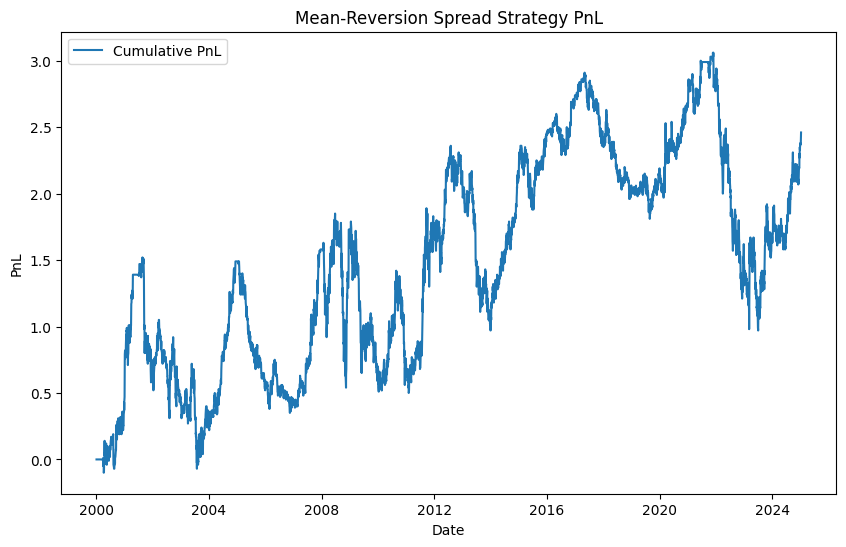

In [23]:
plt.figure(figsize=(10,6))
plt.plot(yields_df.index, yields_df['cum_pnl'], label='Cumulative PnL')
plt.title('Mean-Reversion Spread Strategy PnL')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.show()


Out-of-sample Testing

In [27]:
split_date = '2015-01-01'
train_data = yields_df.loc[:split_date].copy()
test_data = yields_df.loc[split_date:].copy()
# Estime OU parameteres on train set:
kappa_train, theta_train, sigma_train = estimate_ou_params(train_data['spread'].dropna())


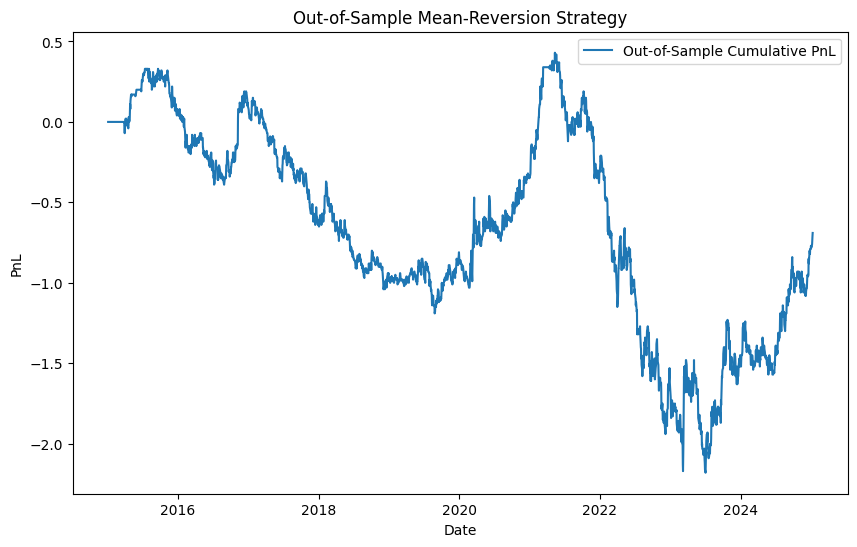

-------------- PERFORMANCE METRICS --------------
Average Daily Return: -0.000275
Daily Std Dev:        0.035559
Annualized Sharpe:    -0.1229
Max Drawdown:         -2.6100
-------------------------------------------------


In [28]:
##############################################################
# 1) OUT-OF-SAMPLE TESTING WITH FIXED TRAINING PARAMETERS
##############################################################

# We already split data:
# split_date = '2015-01-01'
# train_data = yields_df.loc[:split_date].copy()
# test_data = yields_df.loc[split_date:].copy()
# kappa_train, theta_train, sigma_train = estimate_ou_params(train_data['spread'].dropna())

import numpy as np
import matplotlib.pyplot as plt

# -------------- Helper Function: Apply Strategy Logic --------------
def apply_strategy(df, theta_value, threshold_std=1.0, rolling_window=60):
    """
    Applies a simple mean-reversion strategy:
      - If spread > theta + threshold_std * rolling_std => short
      - If spread < theta - threshold_std * rolling_std => long
      - Else => flat

    Returns: A DataFrame with signals, positions, daily PnL, and cumulative PnL.
    """
    # 1. Calculate rolling std
    df['rolling_std'] = df['spread'].rolling(rolling_window).std()

    # 2. Generate signals based on threshold
    signals = []
    for i in range(len(df)):
        spread_val = df['spread'].iloc[i]
        std_val = df['rolling_std'].iloc[i]
        if np.isnan(std_val):
            # Not enough data in the rolling window
            signals.append(0)
            continue

        upper_bound = theta_value + threshold_std * std_val
        lower_bound = theta_value - threshold_std * std_val

        if spread_val > upper_bound:
            signals.append(-1)  # short the spread
        elif spread_val < lower_bound:
            signals.append(1)   # long the spread
        else:
            signals.append(0)   # flat
    df['signal'] = signals

    # 3. Convert signals to positions (one approach: hold until signal changes back to 0)
    position = 0
    positions = []
    for sig in signals:
        if sig != 0:
            position = sig
        else:
            position = 0
        positions.append(position)
    df['position'] = positions

    # 4. Compute daily spread changes
    df['spread_change'] = df['spread'].diff()

    # 5. Calculate daily PnL = previous day position * daily change in spread
    df['strategy_pnl'] = df['position'].shift(1) * df['spread_change']

    # 6. (Optional) Subtract transaction costs:
    # Each time position changes (from 0 to 1, 0 to -1, or from -1 to 1, etc.) => cost
    trade_signals = (df['position'].diff() != 0).astype(int)
    cost_per_trade = 0.01  # example cost
    df['strategy_pnl'] = df['strategy_pnl'] - trade_signals * cost_per_trade

    # 7. Cumulative PnL
    df['cum_pnl'] = df['strategy_pnl'].cumsum()

    return df

# -------------- Helper Function: Performance Metrics --------------
def compute_performance_metrics(df, pnl_col='strategy_pnl', freq=252):
    """
    Computes and prints basic performance metrics:
      - Average Daily Return
      - Daily Std Dev
      - Annualized Sharpe
      - Max Drawdown
    """
    daily_pnl = df[pnl_col].dropna()
    avg_daily_ret = daily_pnl.mean()
    std_daily_ret = daily_pnl.std()

    # Annualized Sharpe (assuming freq trading days per year)
    sharpe_ratio = (avg_daily_ret / std_daily_ret) * np.sqrt(freq) if std_daily_ret != 0 else np.nan

    # Compute equity curve
    equity_curve = daily_pnl.cumsum()
    running_max = equity_curve.cummax()
    drawdown = equity_curve - running_max
    max_drawdown = drawdown.min()

    print("-------------- PERFORMANCE METRICS --------------")
    print(f"Average Daily Return: {avg_daily_ret:.6f}")
    print(f"Daily Std Dev:        {std_daily_ret:.6f}")
    print(f"Annualized Sharpe:    {sharpe_ratio:.4f}")
    print(f"Max Drawdown:         {max_drawdown:.4f}")
    print("-------------------------------------------------")

# -- Apply the strategy on the TEST set using the TRAINING parameters --
test_data_copy = test_data.copy()  # keep an original safe
test_data_copy = apply_strategy(
    test_data_copy, 
    theta_value=theta_train,       # use the long-term mean from training
    threshold_std=1.0,            # 1.0 as a baseline threshold
    rolling_window=60
)

# Plot the out-of-sample cumulative PnL
plt.figure(figsize=(10,6))
plt.plot(test_data_copy.index, test_data_copy['cum_pnl'], label='Out-of-Sample Cumulative PnL')
plt.title('Out-of-Sample Mean-Reversion Strategy')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.show()

# Compute performance metrics for the TEST period
compute_performance_metrics(test_data_copy, pnl_col='strategy_pnl', freq=252)
